# Block Slide 2
## OCP Description
Let's introduce a second phase to the previous example where the block will have to return to it's original position. Because we know friction will switch direction when we slide the block back, the equations of motion change. Since phase A will not change, lets copy everything up until we start initiating the objective function. 

In [1]:
# 1D Blockslide
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import pycollo

# State variables
x = sym.Symbol("x")  # Position (m) of the point horizontally from the origin (x-axis)
dx = sym.Symbol("dx")  # Velocity (m/s) of the point horizontally (x-axis)
# Control variables
Fx = sym.Symbol("Fx")  # Force (N) applied to the point horizontally (x-axis)

# Static parameter variable
g = sym.Symbol("g")  # Gravitational acceleration (m/s^2)
m = sym.Symbol("m")  # Mass (kg) of the point
mu = sym.Symbol("mu") # Coefficient of friction (-)

# Problem instantiation
problem = pycollo.OptimalControlProblem(
    name="Simple Block Slide",
    parameter_variables= (m,mu))
    
problem.bounds.parameter_variables = [[1,2], [0.5,1]]
problem.guess.parameter_variables = [1.5, 0.75]
problem.auxiliary_data = {g: 9.81}

phase_A = problem.new_phase(name="A")
phase_A.bounds.initial_time = 0
phase_A.bounds.final_time = [0, 10]
phase_A.guess.time = [0, 1]

phase_A.state_variables = [x, dx]
phase_A.bounds.state_variables = [[-3,3],[-50,50]]
phase_A.bounds.state_variables = {
    x: [-3, 3],
    dx: [-50, 50],}
phase_A.bounds.initial_state_constraints = {
    x: 0,
    dx: 0,}
phase_A.bounds.final_state_constraints = {
    x: 1,
    dx: 0,}
phase_A.guess.state_variables = [[0, 0], [0, 0]]

phase_A.control_variables = [Fx]
phase_A.bounds.control_variables = {
    Fx: [-50, 50],}
phase_A.guess.control_variables = [
        [0, 0],]

phase_A.state_equations = {
    x: dx,
    dx: Fx / m - m*g*mu,}

phase_A.integrand_functions = [Fx ** 2]
phase_A.bounds.integral_variables = [[0, 1000]]
phase_A.guess.integral_variables = [0]

## New phase
Now we can copy the previous phase completely to initiate a new phase completely the same. When doing this make sure you overwrite everything that changes in this next phase. It is real easy to make mistakes like this and it is recommended to write out the full phase description as depicted above.

In [2]:
phase_B = problem.new_phase_like(
    phase_for_copying=phase_A,
    name="B",)

Now we can start overwriting everything that will be different from the previous phase:

- Time 
    Phase B initial time can start any moment within bounds, final time the same
- Initial and final state constraints
    The block starts at final state of phase A, and will end at 0.
- State equations
    Friction changes sign

In [3]:
# Time 
phase_B.bounds.initial_time = [0, 10]
phase_B.bounds.final_time = [0, 10]
phase_B.guess.time = [1, 2]

# Initial and final state constraints
phase_B.bounds.initial_state_constraints = {
    x: 1,
    dx: 0,}
phase_B.bounds.final_state_constraints = {
    x: 0,
    dx: 0,}

# State equations
phase_B.state_equations = {
    x: dx,
    dx: Fx / m + m*g*mu,}

## Endpoint constraints
To make sure all variables are continious, sometimes endpoint constraints need to be implemented. Endpoint constraints are constraintes which exist of initial and final variables. When final and initial states are not bound to a single value, phase A final states should match phase B initial states to make the states continious. In this example, the states are constrainted to be continious due to the initial and final state constraints of both phases. Time variables are not constrained to be continious (yet) thus we can implement the following inequality constraint (final time phase A = initial time phase B -> final time phase A - initial time phase B = 0):

In [4]:
problem.endpoint_constraints = [
    phase_A.final_time_variable - phase_B.initial_time_variable,]
    
problem.bounds.endpoint_constraints = [
    0,]

## Objective function - multiphase
Now the objective to minimize input force Fx should als be updated to consider both phases, the integrand functions are created with the copying of the new phase but are yet to be implemented in the objective:

In [5]:
problem.objective_function = (
    phase_A.integral_variables[0] + phase_B.integral_variables[0])
# Bug
phase_B.guess.integral_variables = 0

### Solve


Initialising optimal control problem.

Phase variables and equations checked.
Pycollo variables and constraints preprocessed.
Backend initialised.
Bounds checked.
Problem scaling initialised.
Quadrature scheme initialised.
Backend postprocessing complete.
Initial mesh created.
Initial guess checked.

Initialising mesh iteration #1.

Guess interpolated to iteration mesh in 1.26ms.
Scaling initialised in 64.46us.
Initial guess scaled in 4.83us.
Scaling generated in 3.71ms.
NLP generated in 121.48ms.
Mesh-specific bounds generated in 258.42us.

Mesh iteration #1 initialised in 126.78ms.


Solving mesh iteration #1.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
***********************************************************************

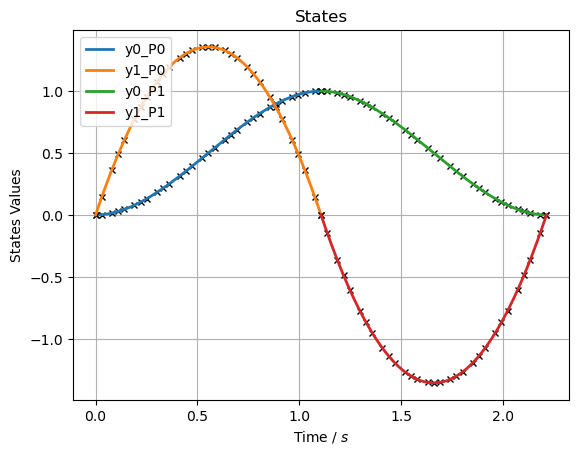

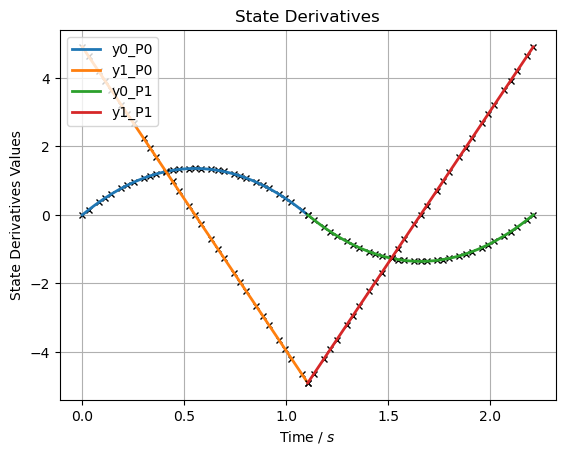

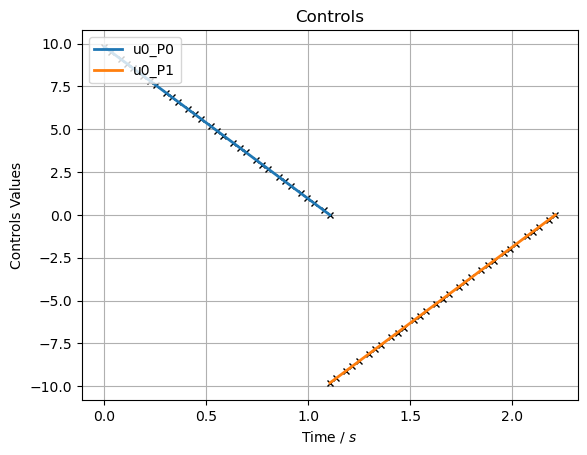

Mesh tolerance met in mesh iteration 1.


Optimal control problem sucessfully solved.

Final Objective Function Evaluation: 70.9582



In [6]:
problem.settings.display_mesh_result_graph = True
problem.initialise()
problem.solve()

### Solution
All results can be found in problem.solution, see [INSERT_LINK_TO_SOLUTION]